# Demo: Language Modeling
Demostrate typical usages for debugging a Language Model

### Defining a wrapper to use diagnostics tools

In [1]:
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F


class GPT2LMModelWrapper(nn.Module):
    def __init__(self, model) -> None:
        super(GPT2LMModelWrapper, self).__init__()
        self.m = model

    def forward(self, inputs_embeds, attention_mask) -> Tensor:
        output = self.m(
            inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).logits[:, -1, :]
        return F.softmax(output, -1)

### Language Modeling predicting next word using gpt2

In [2]:
import transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

text_input = "Can humans dream of electric sheep ? This is a"
# text_input = "This knife is very"
# text_input = "Machine learning with pytorch and nn-diagnostics can do amazing"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", return_dict=True, is_decoder=True)

inputs = tokenizer(text_input, return_tensors="pt")
output = model(**inputs).logits[:, -1, :]
softmax = F.softmax(output, -1)
values, predictions = softmax.topk(3)

for i, v in enumerate(values[0]):
    p = predictions[0][i]
    x = tokenizer.decode(p)
    print("prediction:", x, " prob:", v.item())

prediction:  question  prob: 0.1330832540988922
prediction:  very  prob: 0.0609452985227108
prediction:  great  prob: 0.03137362748384476


In [3]:
from diagnostics import get_gradients

# Preprocess inputs ids to embedings, otherwise we can't get gradients
inputs_embeds = model.transformer.wte(inputs["input_ids"])
# Use zero embeddings as baseline
baseline = [torch.zeros(inputs_embeds.shape), inputs["attention_mask"]]
# Set target to highest prob prediction
target = torch.zeros((1, tokenizer.vocab_size))
target[0][predictions[0][0]] = 1
md = GPT2LMModelWrapper(model)
gradients = get_gradients(
    md, [inputs_embeds, inputs["attention_mask"]], baseline, target
)
input_grad = torch.linalg.norm(gradients[0], dim=2)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np


def plot_gradients(tokens, gradients, title):
    fig, ax = plt.subplots(figsize=(21, 3))
    xvals = [x + str(i) for i, x in enumerate(tokens)]
    norm_grad = (gradients - np.min(gradients)) / (
        np.max(gradients) - np.min(gradients)
    )
    cmap = plt.colormaps["GnBu"]
    plt.tick_params(axis="both", which="minor", labelsize=29)
    p = plt.bar(xvals, gradients, color=cmap(norm_grad), linewidth=1)
    fig.colorbar(
        plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap),
        ax=ax,
        label="Normalized Color Map",
    )
    plt.title(title)
    p = plt.xticks(
        ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12, rotation=0
    )

In [5]:
tokens = []
for i in inputs["input_ids"][0]:
    tokens.append(tokenizer.decode(i))

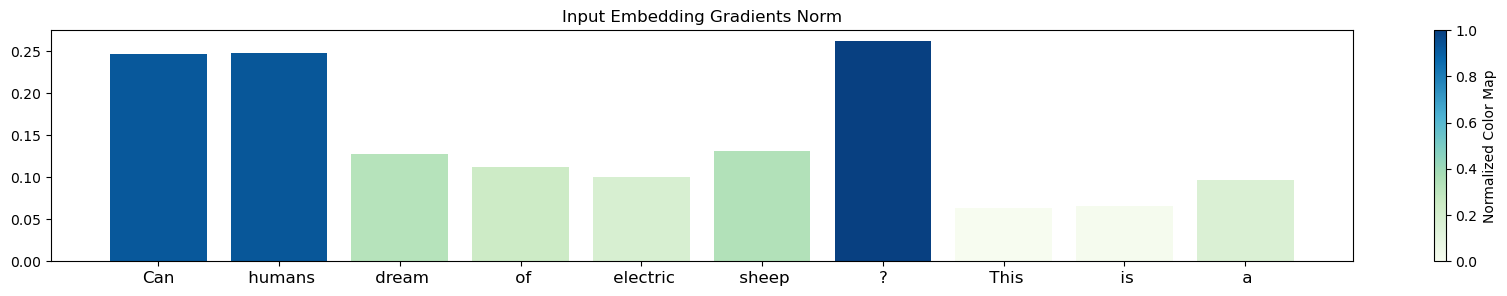

In [6]:
plot_gradients(tokens, input_grad[0].numpy(), "Input Embedding Gradients Norm")